# 🔧 Notebook 02 - Preprocessing avec DeepFace

## Normalisation et Augmentation des Visages Extraits

### Objectif
Prétraiter les visages extraits par DeepFace pour les rendre optimaux pour la reconnaissance faciale.

**Étapes:**
- 1️⃣ Normalisation et Augmentation des données
- 2️⃣ Séparation train/test (80/20)
- 3️⃣ Distribution des données
- 4️⃣ Préparation pour le Federated Learning

---

**Date:** 29 novembre 2025  
**Version:** DeepFace Integration v2  
**Projet:** Trustworthy AI - Extracted Faces Processing

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import yaml
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings('ignore')

# Configuration
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Chemins
current_dir = os.getcwd()
if "notebooks" in current_dir:
    project_root = os.path.dirname(current_dir)
else:
    project_root = current_dir

PROCESSED_DATA_PATH = os.path.join(project_root, 'data', 'processed')
FEDERATED_DATA_PATH = os.path.join(project_root, 'data', 'federated')
LOGS_PATH = os.path.join(project_root, 'logs', 'preprocessing')

os.makedirs(PROCESSED_DATA_PATH, exist_ok=True)
os.makedirs(FEDERATED_DATA_PATH, exist_ok=True)
os.makedirs(LOGS_PATH, exist_ok=True)

# Style
plt.rcParams['figure.figsize'] = (14, 8)
sns.set_style("whitegrid")

print("="*70)
print("🔧 NOTEBOOK 02 - PREPROCESSING AVEC DEEPFACE")
print("="*70)
print(f"\n✅ Configuration terminée!")

🔧 NOTEBOOK 02 - PREPROCESSING AVEC DEEPFACE

✅ Configuration terminée!


## 1. 📥 Charger les Visages Extraits

Charger les visages extraits du Notebook 01 avec DeepFace.

In [2]:
print("\n" + "="*70)
print("📥 CHARGEMENT DES VISAGES EXTRAITS")
print("="*70 + "\n")

# Charger les données extraites
extracted_file = os.path.join(PROCESSED_DATA_PATH, 'raw_extracted_faces.npz')
metadata_file = os.path.join(PROCESSED_DATA_PATH, 'metadata.yaml')

if os.path.exists(extracted_file):
    data = np.load(extracted_file)
    X_extracted = data['X']
    y_labels = data['y']
    
    with open(metadata_file, 'r') as f:
        metadata = yaml.safe_load(f)
    
    print(f"✅ Données chargées:")
    print(f"   • X shape: {X_extracted.shape}")
    print(f"   • y shape: {y_labels.shape}")
    print(f"   • Membres: {metadata['member_names']}")
    print(f"   • Classes: {metadata['num_classes']}")
    
    NUM_CLASSES = metadata['num_classes']
    MEMBER_NAMES = metadata['member_names']
    
else:
    print("⚠️ Fichier raw_extracted_faces.npz non trouvé!")
    print("   Assurez-vous d'avoir exécuté le Notebook 01 avec succès")
    X_extracted = None
    y_labels = None


📥 CHARGEMENT DES VISAGES EXTRAITS

✅ Données chargées:
   • X shape: (600, 224, 224, 3)
   • y shape: (600,)
   • Membres: ['member1', 'member2', 'member3']
   • Classes: 3
✅ Données chargées:
   • X shape: (600, 224, 224, 3)
   • y shape: (600,)
   • Membres: ['member1', 'member2', 'member3']
   • Classes: 3


## 2. 🎨 Normalisation et Augmentation

Normaliser les visages et effectuer une augmentation de données.

In [3]:
if X_extracted is not None:
    print("\n" + "="*70)
    print("🎨 NORMALISATION ET AUGMENTATION")
    print("="*70 + "\n")
    
    # Normaliser entre 0 et 1
    if X_extracted.max() > 1.0:
        X_normalized = X_extracted.astype(np.float32) / 255.0
    else:
        X_normalized = X_extracted.astype(np.float32)
    
    print(f"✅ Normalisation:")
    print(f"   • Range avant: [{X_extracted.min()}, {X_extracted.max()}]")
    print(f"   • Range après: [{X_normalized.min():.3f}, {X_normalized.max():.3f}]")
    
    # ============================================================
    # AUGMENTATION LÉGÈRE POUR AJOUTER ~500 IMAGES
    # ============================================================
    from scipy.ndimage import rotate
    import random
    
    print(f"\n" + "="*70)
    print("📈 AUGMENTATION DES DONNÉES (+500 images)")
    print("="*70)
    
    current_samples = len(X_normalized)
    samples_per_class = current_samples // NUM_CLASSES
    
    # Calculer combien d'images augmentées par classe (~167 par classe pour 500 total)
    IMAGES_TO_ADD = 500
    images_per_class_to_add = IMAGES_TO_ADD // NUM_CLASSES
    
    print(f"\n📊 État initial:")
    print(f"   • Images actuelles: {current_samples}")
    print(f"   • Images par classe: ~{samples_per_class}")
    print(f"   • Images à ajouter: {IMAGES_TO_ADD} (~{images_per_class_to_add}/classe)")
    
    def simple_augment(img):
        """Augmentation simple et rapide."""
        aug_img = img.copy()
        
        # Rotation aléatoire (-15° à +15°)
        angle = random.uniform(-15, 15)
        aug_img = rotate(aug_img, angle, axes=(0, 1), reshape=False, mode='nearest')
        
        # Flip horizontal (50%)
        if random.random() > 0.5:
            aug_img = np.fliplr(aug_img)
        
        # Ajustement de luminosité
        brightness = random.uniform(0.85, 1.15)
        aug_img = np.clip(aug_img * brightness, 0, 1)
        
        return aug_img.astype(np.float32)
    
    # Appliquer l'augmentation par classe
    print(f"\n⏳ Augmentation en cours...")
    
    X_augmented_list = [X_normalized]  # Commencer avec les originaux
    y_augmented_list = [y_labels.copy()]
    
    for class_idx in range(NUM_CLASSES):
        class_mask = y_labels == class_idx
        class_images = X_normalized[class_mask]
        
        print(f"   🔄 {MEMBER_NAMES[class_idx]}: {len(class_images)} → ", end="")
        
        # Sélectionner des images aléatoires à augmenter
        indices_to_augment = np.random.choice(
            len(class_images), 
            min(images_per_class_to_add, len(class_images)), 
            replace=True
        )
        
        augmented_class = []
        for idx in indices_to_augment:
            augmented_class.append(simple_augment(class_images[idx]))
        
        augmented_class = np.array(augmented_class, dtype=np.float32)
        augmented_labels = np.full(len(augmented_class), class_idx)
        
        X_augmented_list.append(augmented_class)
        y_augmented_list.append(augmented_labels)
        
        print(f"{len(class_images) + len(augmented_class)} images (+{len(augmented_class)})")
    
    # Combiner toutes les données
    X_processed = np.concatenate(X_augmented_list, axis=0)
    y_labels = np.concatenate(y_augmented_list, axis=0)
    
    # Mélanger les données
    shuffle_idx = np.random.permutation(len(X_processed))
    X_processed = X_processed[shuffle_idx]
    y_labels = y_labels[shuffle_idx]
    
    print(f"\n" + "="*70)
    print(f"✅ AUGMENTATION TERMINÉE!")
    print(f"="*70)
    print(f"\n📊 Résultat final:")
    print(f"   • Images originales: {current_samples}")
    print(f"   • Images ajoutées: {len(X_processed) - current_samples}")
    print(f"   • Total: {len(X_processed)} images")
    print(f"   • Shape finale: {X_processed.shape}")
    
    print(f"\n📊 Distribution par classe:")
    for class_idx in range(NUM_CLASSES):
        count = np.sum(y_labels == class_idx)
        print(f"   • {MEMBER_NAMES[class_idx]}: {count} images")
    
    print(f"\n✅ Données prêtes pour l'entraînement!")


🎨 NORMALISATION ET AUGMENTATION

✅ Normalisation:
   • Range avant: [0.0, 1.0]
   • Range après: [0.000, 1.000]

📈 AUGMENTATION DES DONNÉES (+500 images)

📊 État initial:
   • Images actuelles: 600
   • Images par classe: ~200
   • Images à ajouter: 500 (~166/classe)

⏳ Augmentation en cours...
✅ Normalisation:
   • Range avant: [0.0, 1.0]
   • Range après: [0.000, 1.000]

📈 AUGMENTATION DES DONNÉES (+500 images)

📊 État initial:
   • Images actuelles: 600
   • Images par classe: ~200
   • Images à ajouter: 500 (~166/classe)

⏳ Augmentation en cours...
   🔄 member1: 200 →    🔄 member1: 200 → 366 images (+166)
   🔄 member2: 200 → 366 images (+166)
   🔄 member2: 200 → 366 images (+166)
   🔄 member3: 200 → 366 images (+166)
   🔄 member3: 200 → 366 images (+166)
366 images (+166)

✅ AUGMENTATION TERMINÉE!

📊 Résultat final:
   • Images originales: 600
   • Images ajoutées: 498
   • Total: 1098 images
   • Shape finale: (1098, 224, 224, 3)

📊 Distribution par classe:
   • member1: 366 imag


🖼️ VISUALISATION DES IMAGES AUGMENTÉES


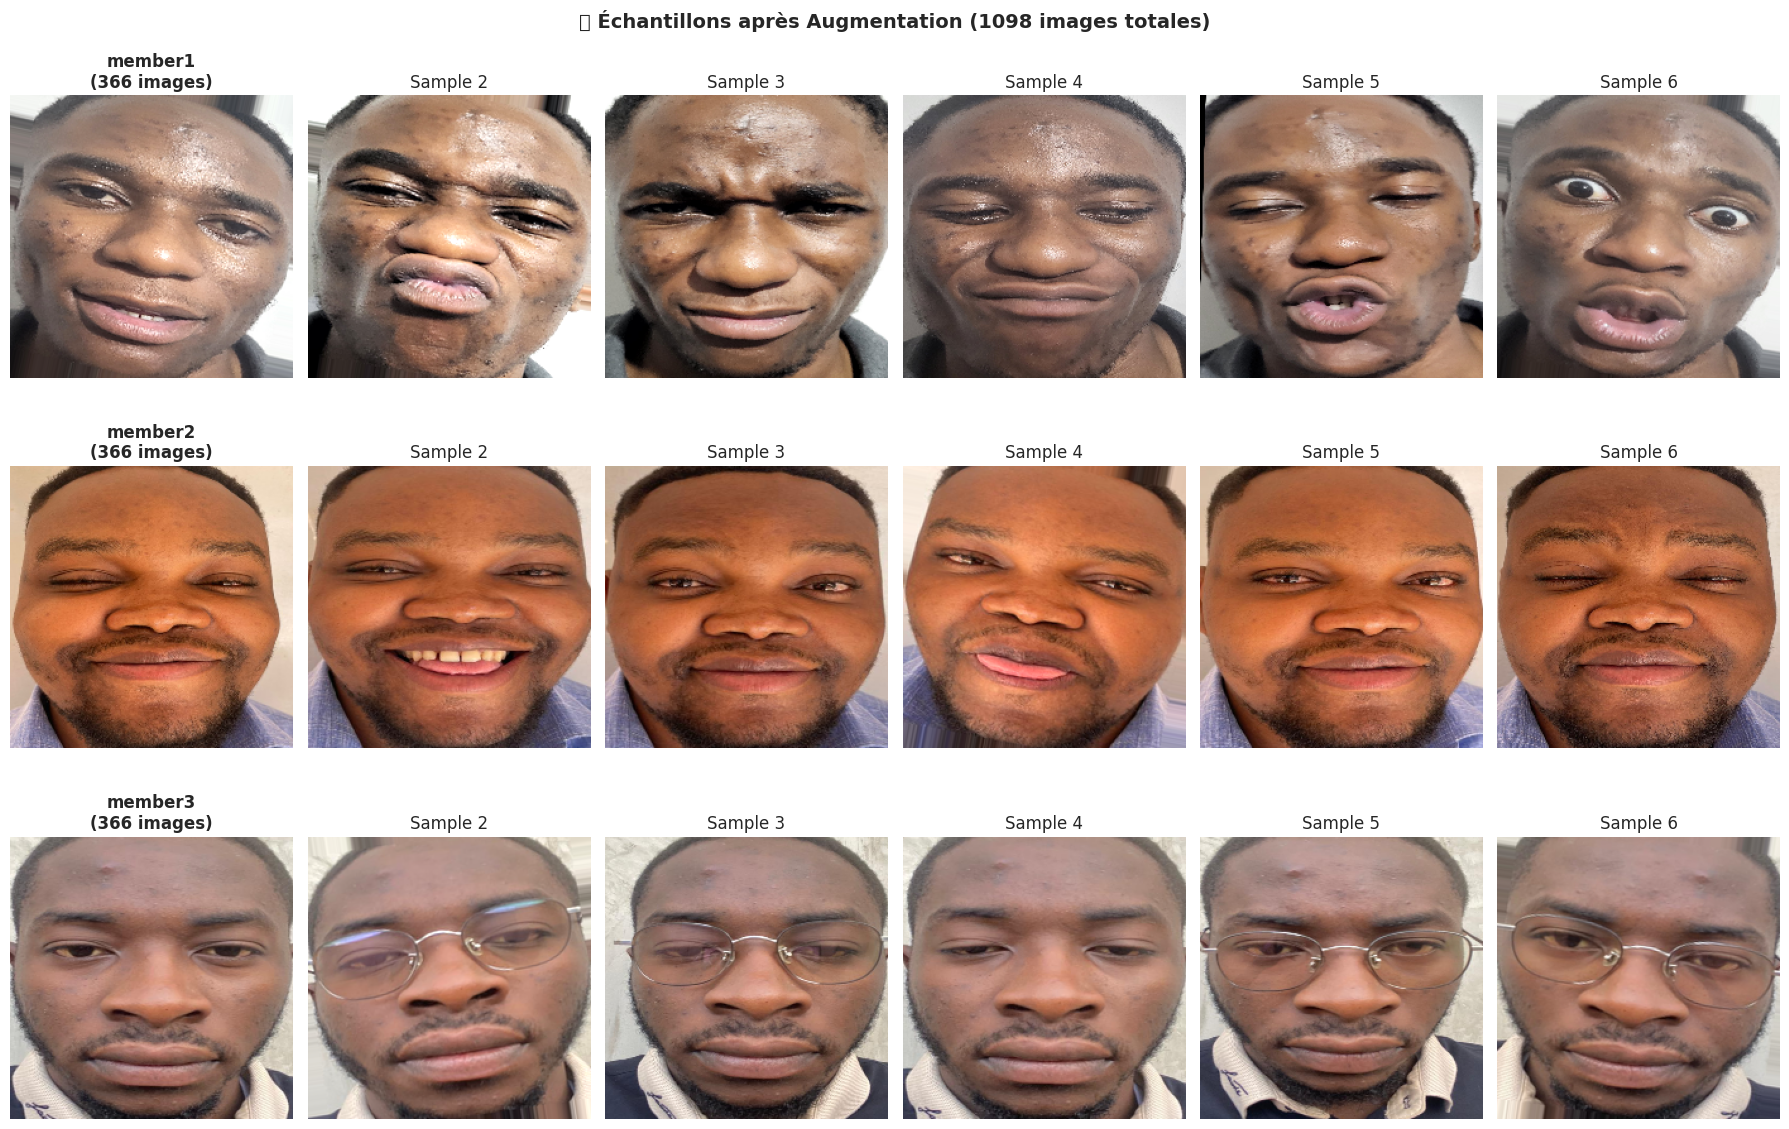


✅ Visualisation sauvegardée: /home/victory/Documents/TrustworthyAI/logs/preprocessing/augmented_samples.png


In [4]:
# Visualisation des images augmentées
print("\n" + "="*70)
print("🖼️ VISUALISATION DES IMAGES AUGMENTÉES")
print("="*70)

fig, axes = plt.subplots(NUM_CLASSES, 6, figsize=(18, 4*NUM_CLASSES))

for class_idx in range(NUM_CLASSES):
    class_mask = y_labels == class_idx
    class_images = X_processed[class_mask]
    
    # Sélectionner 6 images aléatoires
    sample_indices = np.random.choice(len(class_images), min(6, len(class_images)), replace=False)
    
    for j, idx in enumerate(sample_indices):
        img = class_images[idx]
        
        if NUM_CLASSES == 1:
            ax = axes[j]
        else:
            ax = axes[class_idx, j]
        
        ax.imshow(img)
        ax.axis('off')
        if j == 0:
            ax.set_title(f'{MEMBER_NAMES[class_idx]}\n({np.sum(class_mask)} images)', fontweight='bold')
        else:
            ax.set_title(f'Sample {j+1}')

plt.suptitle(f'🎨 Échantillons après Augmentation ({len(X_processed)} images totales)', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(LOGS_PATH, 'augmented_samples.png'), dpi=150)
plt.show()

print(f"\n✅ Visualisation sauvegardée: {os.path.join(LOGS_PATH, 'augmented_samples.png')}")

## 3. 📊 Séparation Train/Test

Diviser les données en ensembles d'entraînement et de test.

In [7]:
if X_extracted is not None:
    print("\n" + "="*70)
    print("📊 SÉPARATION TRAIN/TEST (80/20)")
    print("="*70 + "\n")
    
    # Séparation stratifiée: 80% train, 20% test
    X_train, X_test, y_train, y_test = train_test_split(
        X_processed, y_labels, 
        test_size=0.2, 
        stratify=y_labels, 
        random_state=42
    )
    
    print(f"✅ Séparation réalisée:")
    print(f"   • Train: {X_train.shape} ({100*len(X_train)/len(X_processed):.1f}%)")
    print(f"   • Test:  {X_test.shape} ({100*len(X_test)/len(X_processed):.1f}%)")
    
    # Vérifier la distribution
    print(f"\n📊 Distribution par classe:")
    for member_idx, member in enumerate(MEMBER_NAMES):
        train_count = np.sum(y_train == member_idx)
        test_count = np.sum(y_test == member_idx)
        print(f"   • {member}: train={train_count}, test={test_count}")
    
    # Sauvegarder
    print(f"\n💾 Sauvegarde des données...")
    
    processed_file = os.path.join(PROCESSED_DATA_PATH, 'processed_faces.npz')
    np.savez(processed_file,
             X_train=X_train, y_train=y_train,
             X_test=X_test, y_test=y_test)
    
    print(f"✅ Données sauvegardées: {processed_file}")
    
    # Sauvegarder aussi les fichiers séparés pour le federated learning
    for member_idx, member in enumerate(MEMBER_NAMES):
        mask_train = y_train == member_idx
        mask_test = y_test == member_idx
        
        client_file = os.path.join(FEDERATED_DATA_PATH, f'{member}.npz')
        np.savez(client_file,
                 X_train=X_train[mask_train],
                 y_train=y_train[mask_train],
                 X_test=X_test[mask_test],
                 y_test=y_test[mask_test])
        
        print(f"   ✅ Client {member}: {np.sum(mask_train)} train, {np.sum(mask_test)} test")
    
    print(f"\n✅ PREPROCESSING TERMINÉ!")
    print(f"\n📁 Fichiers générés:")
    print(f"   • {processed_file}")
    print(f"   • {os.path.join(FEDERATED_DATA_PATH, '*.npz')} (par client)")


📊 SÉPARATION TRAIN/TEST (80/20)

✅ Séparation réalisée:
   • Train: (878, 224, 224, 3) (80.0%)
   • Test:  (220, 224, 224, 3) (20.0%)

📊 Distribution par classe:
   • member1: train=293, test=73
   • member2: train=293, test=73
   • member3: train=292, test=74

💾 Sauvegarde des données...
✅ Séparation réalisée:
   • Train: (878, 224, 224, 3) (80.0%)
   • Test:  (220, 224, 224, 3) (20.0%)

📊 Distribution par classe:
   • member1: train=293, test=73
   • member2: train=293, test=73
   • member3: train=292, test=74

💾 Sauvegarde des données...
✅ Données sauvegardées: /home/victory/Documents/TrustworthyAI/data/processed/processed_faces.npz
✅ Données sauvegardées: /home/victory/Documents/TrustworthyAI/data/processed/processed_faces.npz
   ✅ Client member1: 293 train, 73 test
   ✅ Client member1: 293 train, 73 test
   ✅ Client member2: 293 train, 73 test
   ✅ Client member2: 293 train, 73 test
   ✅ Client member3: 292 train, 74 test

✅ PREPROCESSING TERMINÉ!

📁 Fichiers générés:
   • /home/

## 4. 📋 Rapport Final du Preprocessing

Synthèse complète des opérations de prétraitement effectuées.

In [8]:
from datetime import datetime

print("\n" + "="*80)
print("📋 RAPPORT FINAL - NOTEBOOK 02 - PREPROCESSING")
print("="*80)

# Calculer les statistiques d'augmentation
original_samples = len(X_extracted)
augmented_total = len(X_processed)
images_added = augmented_total - original_samples

final_report = f"""
╔════════════════════════════════════════════════════════════════════════════╗
║                    🔧 SYNTHÈSE DU PREPROCESSING                            ║
╚════════════════════════════════════════════════════════════════════════════╝

📌 DATE ET CONTEXTE
   • Date d'exécution: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
   • Notebook: 02_preprocessing.ipynb
   • Source: Visages extraits par DeepFace (Notebook 01)

═══════════════════════════════════════════════════════════════════════════════

1️⃣ 📥 DONNÉES D'ENTRÉE (ORIGINALES)
   ├─ Fichier source: {extracted_file}
   ├─ Shape originale: {X_extracted.shape}
   ├─ Membres: {MEMBER_NAMES}
   └─ Total samples originaux: {original_samples}

═══════════════════════════════════════════════════════════════════════════════

2️⃣ 🎨 NORMALISATION
   ├─ Range avant: [{X_extracted.min():.3f}, {X_extracted.max():.3f}]
   ├─ Range après: [{X_processed.min():.3f}, {X_processed.max():.3f}]
   ├─ Type: float32
   └─ Status: ✅ Normalisé [0, 1]

═══════════════════════════════════════════════════════════════════════════════

3️⃣ 📈 AUGMENTATION DES DONNÉES
   ├─ Images originales: {original_samples}
   ├─ Images ajoutées: +{images_added}
   ├─ Total après augmentation: {augmented_total}
   ├─ Facteur de multiplication: {augmented_total/original_samples:.2f}x
   │
   ├─ Transformations appliquées:
   │  • 🔄 Rotation aléatoire (-15° à +15°)
   │  • 🪞 Flip horizontal (50% des images)
   │  • ☀️ Ajustement luminosité (0.85x à 1.15x)
   │
   └─ Status: ✅ Augmentation réussie

═══════════════════════════════════════════════════════════════════════════════

4️⃣ 📊 SÉPARATION DES DONNÉES (80/20)
   ├─ Train: {X_train.shape} ({100*len(X_train)/len(X_processed):.1f}%)
   ├─ Test: {X_test.shape} ({100*len(X_test)/len(X_processed):.1f}%)
   └─ Stratification: ✅ Équilibrée par classe

═══════════════════════════════════════════════════════════════════════════════

5️⃣ 👥 DISTRIBUTION PAR MEMBRE (APRÈS AUGMENTATION)
"""

for member_idx, member in enumerate(MEMBER_NAMES):
    train_count = np.sum(y_train == member_idx)
    test_count = np.sum(y_test == member_idx)
    total = train_count + test_count
    final_report += f"   • {member}: train={train_count}, test={test_count} (total={total})\n"

final_report += f"""
═══════════════════════════════════════════════════════════════════════════════

6️⃣ 💾 FICHIERS GÉNÉRÉS
   
   📦 Données principales:
   ├─ {processed_file}
   │  └─ Contient: X_train, y_train, X_test, y_test
   │  └─ Taille: {X_train.shape[0] + X_test.shape[0]} images
   │
   📁 Données Federated Learning:
"""

for member in MEMBER_NAMES:
    final_report += f"   ├─ {os.path.join(FEDERATED_DATA_PATH, member + '.npz')}\n"

final_report += f"""
═══════════════════════════════════════════════════════════════════════════════

7️⃣ ✅ VALIDATIONS ET CONTRÔLES
   ✓ Normalisation [0, 1] appliquée
   ✓ Augmentation (+{images_added} images) réussie
   ✓ Séparation stratifiée 80/20 (équilibre des classes)
   ✓ Données train/test sauvegardées
   ✓ Données par client sauvegardées (Federated Learning)
   ✓ Format compatible CNN (224×224×3)
   ✓ Pas de valeurs manquantes (NaN)

═══════════════════════════════════════════════════════════════════════════════

8️⃣ 📊 RÉSUMÉ STATISTIQUE
   ┌─────────────────────────────────────────────────────────────────────────┐
   │  AVANT AUGMENTATION          │  APRÈS AUGMENTATION                     │
   ├─────────────────────────────────────────────────────────────────────────┤
   │  {original_samples:4d} images                │  {augmented_total:4d} images (+{images_added})                      │
   │  ~{original_samples//NUM_CLASSES:4d} par classe            │  ~{augmented_total//NUM_CLASSES:4d} par classe                        │
   └─────────────────────────────────────────────────────────────────────────┘

═══════════════════════════════════════════════════════════════════════════════

9️⃣ 🚀 PROCHAINES ÉTAPES
   ✅ Notebook 01: Data Exploration (TERMINÉ)
   ✅ Notebook 02: Preprocessing (TERMINÉ)
   ⏭️ Notebook 03: CNN Training
   ⏭️ Notebook 04: Federated Learning
   ⏭️ Notebook 05: Explainability (XAI)
   ⏭️ Notebook 06: Privacy & Security

═══════════════════════════════════════════════════════════════════════════════

✨ STATUS: ✅ PREPROCESSING TERMINÉ AVEC SUCCÈS
📈 Dataset augmenté: {original_samples} → {augmented_total} images
💾 Données prêtes pour l'entraînement CNN (Notebook 03)
🎯 Continuez avec le Notebook 03

╚════════════════════════════════════════════════════════════════════════════╝
"""

print(final_report)
print("="*80)


📋 RAPPORT FINAL - NOTEBOOK 02 - PREPROCESSING

╔════════════════════════════════════════════════════════════════════════════╗
║                    🔧 SYNTHÈSE DU PREPROCESSING                            ║
╚════════════════════════════════════════════════════════════════════════════╝

📌 DATE ET CONTEXTE
   • Date d'exécution: 2025-11-29 12:46:21
   • Notebook: 02_preprocessing.ipynb
   • Source: Visages extraits par DeepFace (Notebook 01)

═══════════════════════════════════════════════════════════════════════════════

1️⃣ 📥 DONNÉES D'ENTRÉE (ORIGINALES)
   ├─ Fichier source: /home/victory/Documents/TrustworthyAI/data/processed/raw_extracted_faces.npz
   ├─ Shape originale: (600, 224, 224, 3)
   ├─ Membres: ['member1', 'member2', 'member3']
   └─ Total samples originaux: 600

═══════════════════════════════════════════════════════════════════════════════

2️⃣ 🎨 NORMALISATION
   ├─ Range avant: [0.000, 1.000]
   ├─ Range après: [0.000, 1.000]
   ├─ Type: float32
   └─ Status: ✅ Normalisé